In [1]:
import sys
sys.path.append('../src')

import os
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm

import dataloader

%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

model_name = 'unet01-unet'
data_dir = '/mnt/conus3/jason_conus3/'
results_dir = '/mnt/mlnas01/stock/'
ymax = 60

/home/stock/bin/miniconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


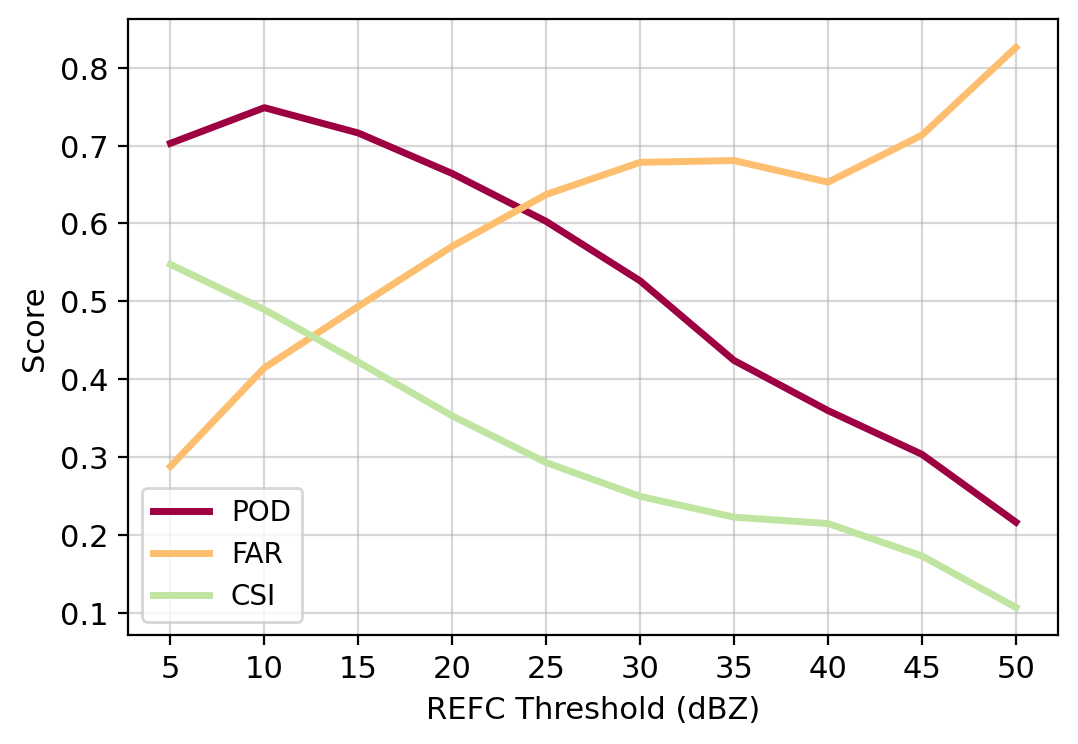

In [4]:
# load json formated string file
model = 'unet01-unet' # 'complete01-vit'
with open(f'/mnt/mlnas01/stock/{model}/stats.json') as f:
    stats = json.loads(json.load(f))

media_path = '../media'

cmap = plt.get_cmap('Spectral', 4)

fontsize = 11
lw = 2.5
metrics = ['pod', 'far', 'csi'] # bias
ls = ['-', '--', ':']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i, m in enumerate(metrics):
    ax.plot(stats['ref'], np.array(stats[m]),
            label=m.upper(), ls=ls[0], lw=lw, color=cmap(i))
ax.set_xticks(stats['ref'])

ax.set_xlabel('REFC Threshold (dBZ)', fontsize=fontsize)
ax.set_ylabel('Score', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(fontsize=fontsize-1)
ax.grid(alpha=0.4)

fig.savefig(os.path.join(media_path, f'refc_stats_{model}.png'),
            dpi=300, bbox_inches='tight')

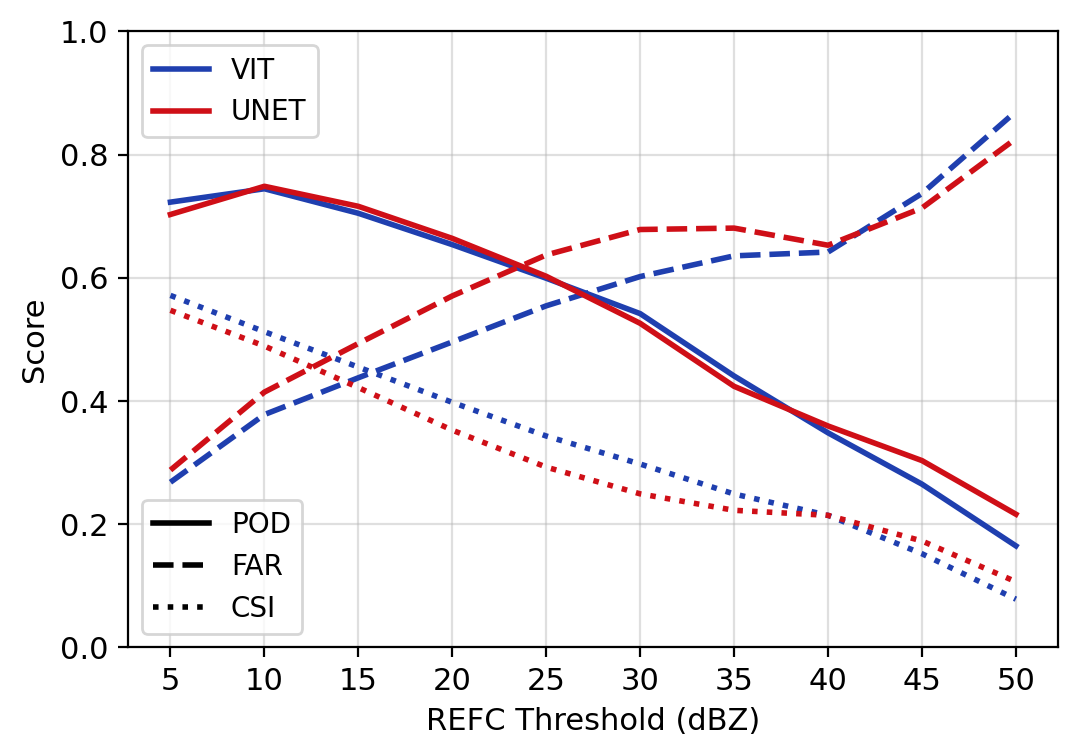

In [229]:
media_path = '../media'
# cmap = plt.get_cmap('Spectral', 10)
# colors = [cmap(8), cmap(2)]
colors = np.array([( 31,  63, 175), (207,  15,  23)]) / 255.
ls = ['-', '--', ':']

fontsize = 11
lw = 2.0

metrics = ['pod', 'far', 'csi'] # bias
models = ['complete01-vit', 'unet01-unet']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i in range(len(models)):
    # load json formated string file
    with open(f'/mnt/mlnas01/stock/{models[i]}/stats.json') as f:
        stats = json.loads(json.load(f))

    for j, m in enumerate(metrics):
        pl = ax.plot(stats['ref'], np.array(stats[m]), label=m.upper(),
                     ls=ls[j], lw=lw, color=colors[i])
        
ax.set_xticks(stats['ref'])

ax.set_xlabel('REFC Threshold (dBZ)', fontsize=fontsize)
ax.set_ylabel('Score', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.grid(alpha=0.4)
ax.set_ylim([0, 1])

model_labels = [m.split('-')[1].upper() for m in models]
h = [plt.plot([],[], color=colors[i], ls='-', lw=lw)[0] for i in range(len(model_labels))]
legend1 = ax.legend(handles=h, labels=model_labels, fontsize=fontsize-1)

h2 = [plt.plot([],[], color='black', ls=ls[i], lw=lw)[0] for i in range(len(metrics))]
ax.legend(handles=h2, labels=[m.upper() for m in metrics], fontsize=fontsize-1, loc='lower left')
ax.add_artist(legend1)

fig.savefig(os.path.join(media_path, f'refc_stats_multiple.png'),
            dpi=300, bbox_inches='tight')

In [2]:
def get_data(filename):
    loss, met = [], [] # assumes (train, val) dims
    with open(filename) as fi:
        for ln in fi:
            if ln.startswith('train loss'):
                ln = ln.rstrip()
                loss.append(re.findall(r'loss: (\d+\.\d+)', ln))
                met.append(re.findall(r'met: (\d+\.\d+)', ln))

    loss = np.stack(loss).astype(float)
    met = np.stack(met).astype(float)
    return loss, met

In [3]:
log = 'log_4656'
loss, met = get_data(f'../logs/{log}.out')

/tmp/tmp.WBZVOww7Er/ipykernel_4071090/3064292141.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral', 8)


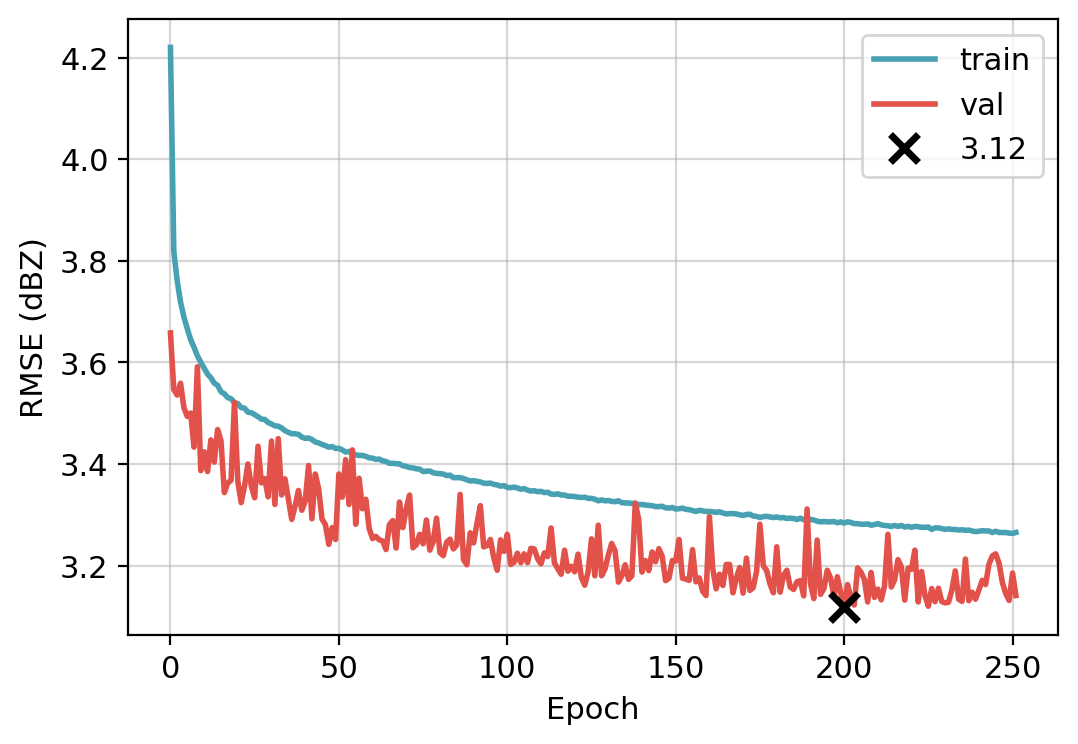

In [4]:
cmap = cm.get_cmap('Spectral', 8)

fontsize = 11
lw = 2
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(met[:,0] * ymax, label='train', ls='-', lw=lw,
        color=cmap(6))
ax.plot(met[:,1] * ymax, label='val', ls='-', lw=lw, 
        color=cmap(1))
min_x = np.argmin(met[:,1])
min_y = met[min_x,1] * ymax
ax.plot(min_x, min_y, 'x', color='black', ms=10, mew=2.5, label=f'{min_y:.2f}')
ax.set_xlabel('Epoch', fontsize=fontsize)
ax.set_ylabel('RMSE (dBZ)', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(fontsize=fontsize)
ax.grid(alpha=0.5)
fig.savefig(os.path.join('../media', f'{log}_loss.png'), dpi=300, bbox_inches='tight')

In [9]:
xt_samples = []
v = os.path.join(data_dir, 'test')
for f in os.listdir(v):
    if 'regA' in f and f.endswith('.npz'):
        xt_samples.append(os.path.join(v, f))
xt_samples.sort()

y_samples = []
v = os.path.join(results_dir, model_name)
for f in os.listdir(v):
    if f.endswith('.npy'):
        y_samples.append(os.path.join(v, f))
y_samples.sort()

In [11]:
rmse = lambda t, y: np.sqrt(np.mean((y - t)**2))
mse = lambda t, y: np.mean((y - t)**2)

def load_xty(xt, y, idx):
    with np.load(xt[idx]) as data:  # C x H x W
        x = np.flip(np.moveaxis(data['xdata'], -1, 0), axis=1)
        t = np.flip(data['ydata'][np.newaxis, ...], axis=1) * ymax

    y = np.flip(np.load(y[idx]), axis=1) * ymax
    
    return x, t, y

In [12]:
index = 15000
x, t, y = load_xty(xt_samples, y_samples, index)
print(x.shape, t.shape, y.shape)

(4, 768, 1536) (1, 768, 1536) (1, 768, 1536)


In [48]:
shape = ts.shape[1:]
n = 0
diffs = 0
for i in zip(ts, ys):
    x, t, y = load_xty(xt_samples, y_samples, i)
    diffs += np.sum((t - y)**2)
    n += 1
np.sqrt(diffs / (n * np.prod(shape)))

197.308524973401

(4, 768, 1536) (1, 768, 1536) (1, 768, 1536)
rmse: 3.48781, rmse: 12.16485


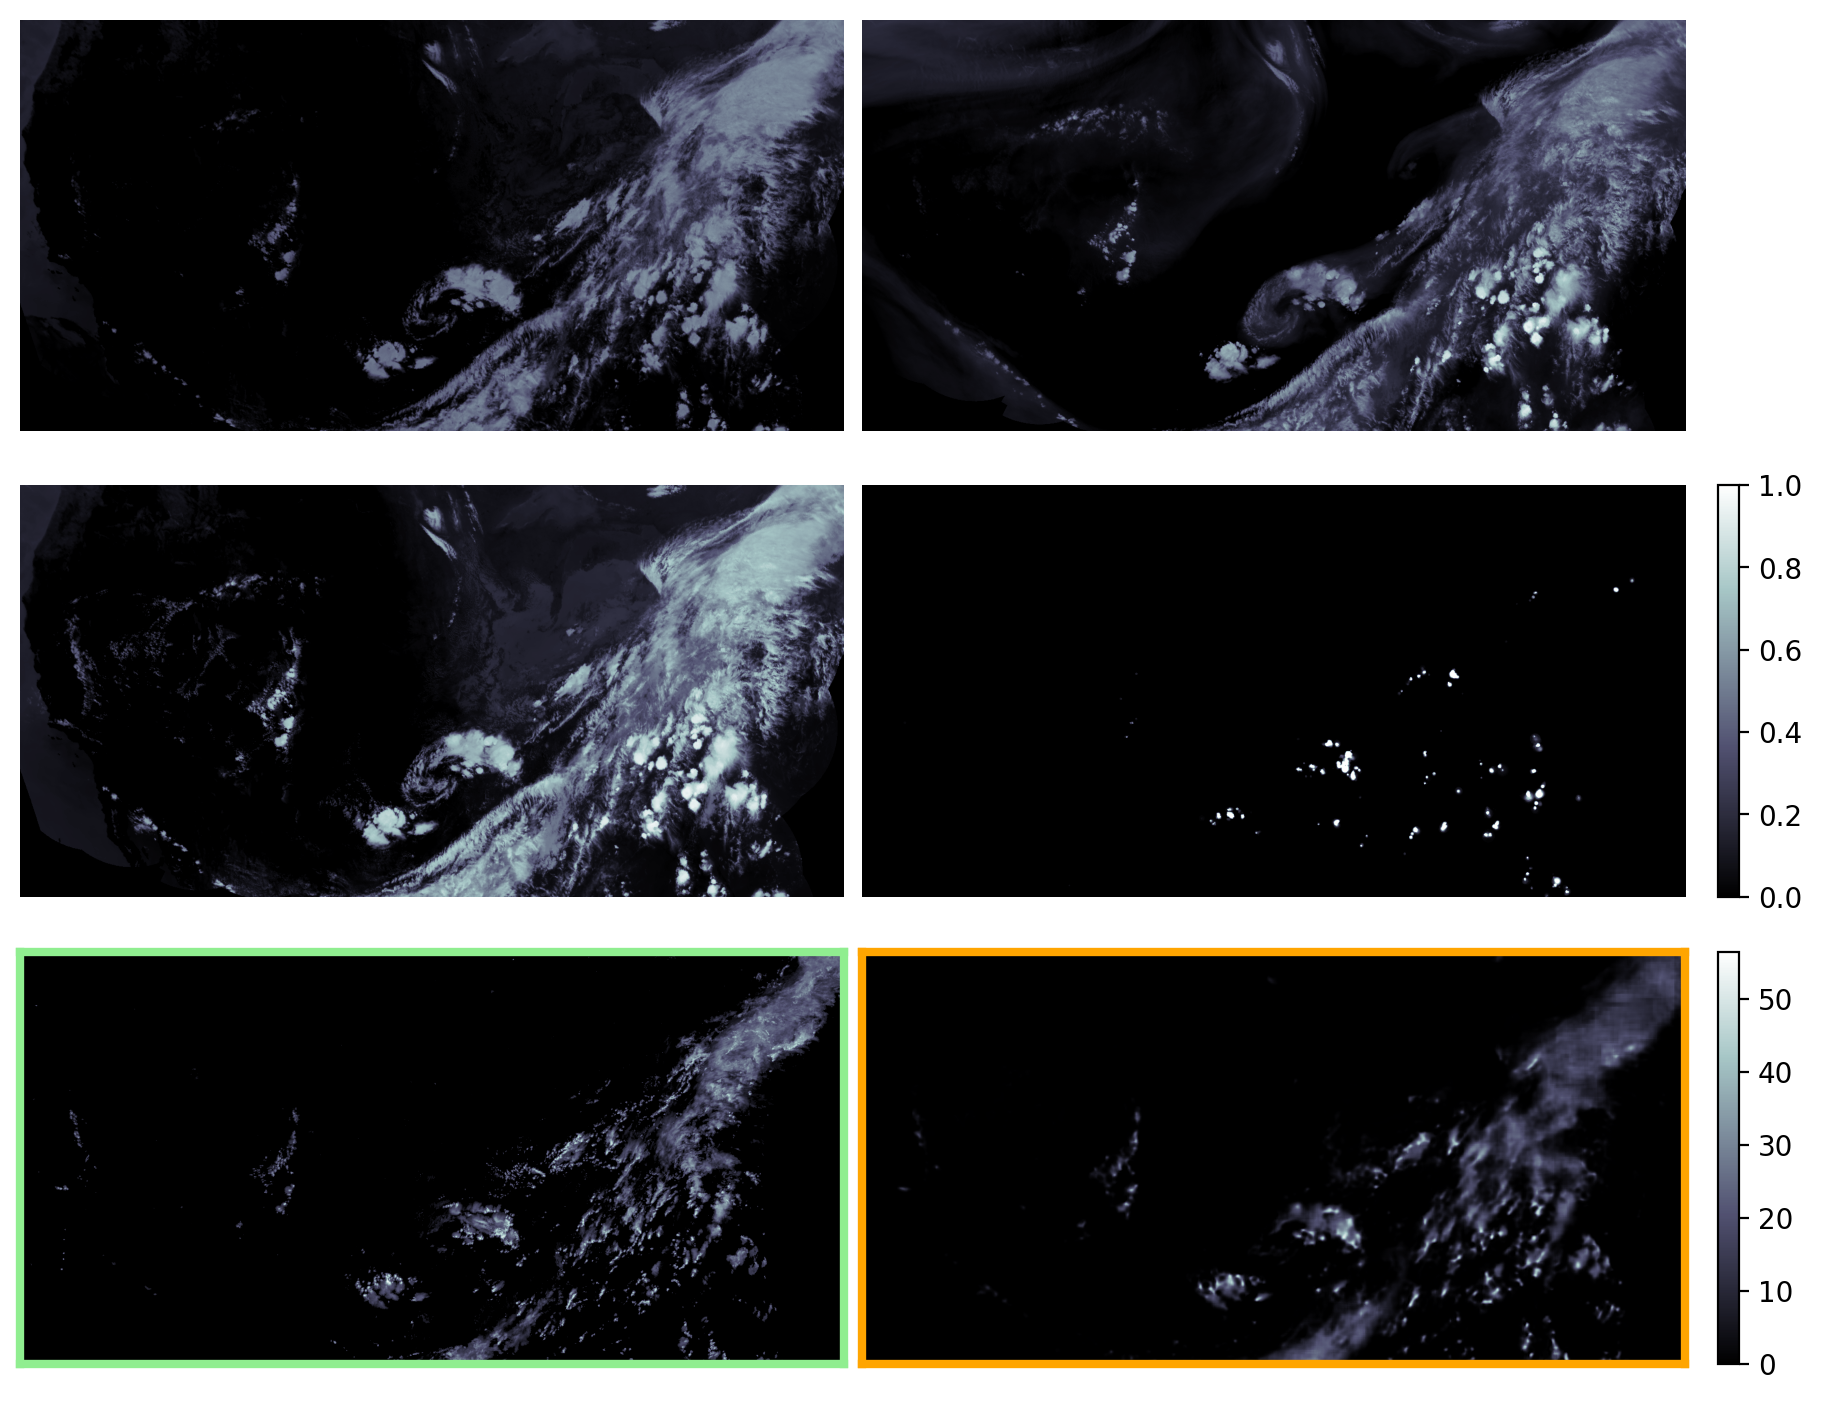

In [13]:
index = 15000
x, t, y = load_xty(xt_samples, y_samples, index)
print(x.shape, t.shape, y.shape)

fig, axs = plt.subplots(3, 2, figsize=(9,7), constrained_layout=True)
axs = axs.ravel()
for i in range(x.shape[0]):
    imx = axs[i].imshow(x[i], cmap='bone', vmin=x.min(), vmax=x.max())
    axs[i].axis('off')
fig.colorbar(imx, ax=axs[3], fraction=0.025, pad=0.04)

axs[-2].imshow(t[0], cmap='bone', vmin=t.min(), vmax=t.max())
imt = axs[-1].imshow(y[0], cmap='bone', vmin=t.min(), vmax=t.max())
fig.colorbar(imt, ax=axs[-1], fraction=0.025, pad=0.04)

for spine in axs[-2].spines.values():
    spine.set_edgecolor('lightgreen')
    spine.set_linewidth(3)

for spine in axs[-1].spines.values():
    spine.set_edgecolor('orange')
    spine.set_linewidth(3)

for ax in axs:
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

fig.savefig(f'../media/{log}_test_{index}.png', dpi=300, bbox_inches='tight')

print(f'rmse: {rmse(y, t):.5f}, rmse: {mse(y, t):.5f}')

In [114]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.basemap import Basemap

from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde

In [227]:
dataset = 'train'
distribution_sample_map = np.load(os.path.join(results_dir, f'distribution_sample_map_{dataset}.npy'))
output_sample_counts = np.load(os.path.join(results_dir, f'output_sample_counts_{dataset}.npy')) / np.prod((1, 768, 1536))
top_perc = np.percentile(distribution_sample_map, 99)
distribution_sample_map = distribution_sample_map.clip(0, top_perc)

In [183]:
rgb_colors = [] # new: CVD accessible
rgb_colors.append((231, 231, 231))  #0
rgb_colors.append((111, 239, 255))  #5
rgb_colors.append(( 95, 207, 239))  #10
rgb_colors.append(( 79, 175, 223))  #15
rgb_colors.append(( 47,  95, 191))  #20
rgb_colors.append(( 31,  63, 175))  #25
rgb_colors.append(( 15,  31, 159))  #30
rgb_colors.append((247, 239,  63))  #35
rgb_colors.append((239, 191,  55))  #40
rgb_colors.append((231, 143,  47))  #45
rgb_colors.append((207,  15,  23))  #50
rgb_colors.append((183,   7,  15))  #55
rgb_colors.append((159,   0,   8))  #60

colors = []
for atup in rgb_colors:
    colors.append('#%02x%02x%02x'%atup)

cmap = ListedColormap(colors,'distrib')
cmap.set_over(colors[-1])
cmap.set_under(colors[0])

bounds = np.linspace(0, top_perc, 13).tolist()
ticklabels = [str(a) for a in bounds]

norm = BoundaryNorm(bounds,cmap.N)

/tmp/ipykernel_220557/765091432.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = basemap.pcolormesh(x,y,distribution_sample_map,cmap=cmap,norm=norm)


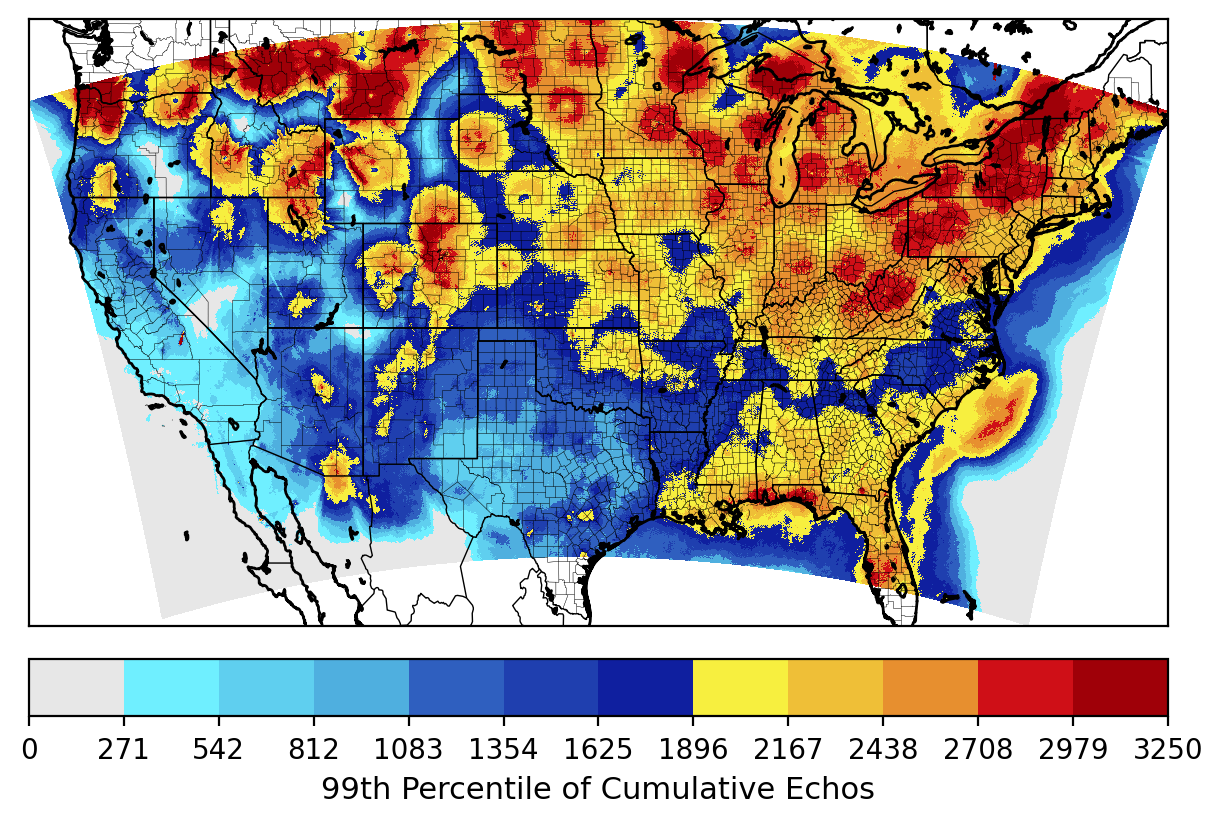

In [184]:
## OLD
# distribution_sample_map = np.flip(distribution_sample_map, axis=0)
# fig, ax = plt.subplots(1,1, figsize=(6,4), constrained_layout=True)
# im = ax.imshow(distribution_sample_map, cmap=cmap, norm=norm)
# ax.axis('off')
# cb = fig.colorbar(im, ax=ax, ticks=bounds, fraction=0.024, pad=0.02)
# # fig.savefig(f'../media/distribution_map_{dataset}.png', dpi=300, bbox_inches='tight')
# plt.show()

hrrr_grid_file = '/mnt/conus3/jason_conus3/code/hrrr_grid.bin'

nlon = 1799
nlat = 1059
count = nlat*nlon
shape = (nlat,nlon)

with open(hrrr_grid_file,'rb') as f:
    lon = np.fromfile(f,dtype=np.float64,count=count).reshape(shape)
    lat = np.fromfile(f,dtype=np.float64,count=count).reshape(shape)

#TODO: close :)
lon = lon[147:nlat-144, 153:nlon-110]
lat = lat[147:nlat-144, 153:nlon-110]

basemap = {}
basemap['projection'] = 'cyl'
basemap['resolution'] = 'i'
basemap['fix_aspect'] = False
basemap['llcrnrlon'] = lon.min()
basemap['urcrnrlon'] = lon.max()
basemap['llcrnrlat'] = lat.min()
basemap['urcrnrlat'] = lat.max()
basemap = Basemap(**basemap)

x,y = basemap(lon,lat)

fontsize = 11

fig = plt.figure(figsize=(6,4), constrained_layout=True)
plt.subplot(1, 1, 1)

pcm = basemap.pcolormesh(x,y,distribution_sample_map,cmap=cmap,norm=norm)

basemap.drawcoastlines()
basemap.drawcountries()
basemap.drawstates()
basemap.drawcounties()

cb = plt.colorbar(pcm,ticks=bounds,orientation='horizontal',fraction=0.1,pad=0.05)
cb.set_label('99th Percentile of Cumulative Echos', fontsize=fontsize)

fig.savefig(f'../media/distribution_map_{dataset}.png', dpi=300, bbox_inches='tight')

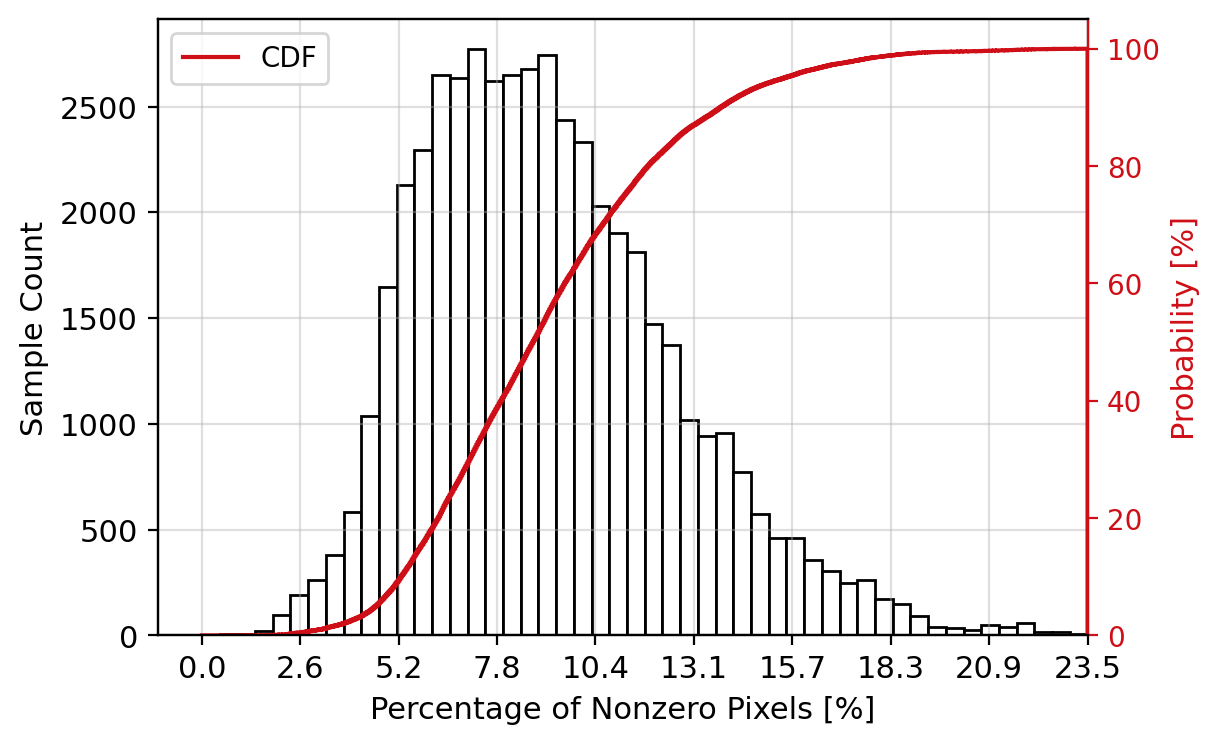

non-zero train data mean: 9.20%


In [228]:
# cmap = plt.get_cmap('Spectral', 8)
# color = cmap(1)
color = (np.array([(207,  15,  23)]) / 255.)[0]
fontsize = 11
lw = 1.5

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.hist(output_sample_counts, bins=50, density=False,
        facecolor='w', edgecolor='k')
# ax.set_title(f'non-zero {dataset} data')
ax.set_xlabel(f'Percentage of Nonzero Pixels [%]', fontsize=fontsize)
ax.set_ylabel(f'Sample Count', fontsize=fontsize)

frequencies = np.linspace(0,  output_sample_counts.max(), 10)
ax.set_xticks(frequencies)
scaled_ticks = [f'{f * 100:.1f}' for f in frequencies]
ax.set_xticklabels(scaled_ticks)

ax2 = ax.twinx()
ax2.hist(output_sample_counts, cumulative=1, lw=lw,
         histtype='step', bins=1000, color=color)
ax.set_xlim((ax.get_xlim()[0], output_sample_counts.max()))
ax2.tick_params(axis='y', colors=color)
ax2.spines['right'].set_color(color)
ax2.set_ylabel('Probability [%]', fontsize=fontsize, color=color)

frequencies = np.linspace(0, len(output_sample_counts), 6)
ax2.set_yticks(frequencies)
scaled_ticks = [f'{int(f / frequencies.max() * 100)}' for f in frequencies]
ax2.set_yticklabels(scaled_ticks)

custom_legend = [Line2D([0],[0], color=color, lw=lw)]
ax2.legend(custom_legend, ['CDF'], fontsize=fontsize-1)

ax.tick_params(axis='both', labelsize=fontsize)

# kds = gaussian_kde(output_sample_counts)
# xs = np.linspace(output_sample_counts.min(), 
#                  output_sample_counts.max(), 1000)
# ax.plot(xs, kds(xs), '-k')

ax.grid(alpha=0.4)
fig.savefig(f'../media/distribution_{dataset}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'non-zero {dataset} data mean: {output_sample_counts.mean() * 100:.2f}%')